In [4]:

!pip install xgboost


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from xgboost import XGBClassifier

In [6]:
df = pd.read_csv("Spotify_data.csv")
df.head()


,Age,Gender,spotify_usage_period,spotify_listening_device,spotify_subscription_plan,premium_sub_willingness,preffered_premium_plan,preferred_listening_content,fav_music_genre,music_time_slot,music_Influencial_mood,music_lis_frequency,music_expl_method,music_recc_rating,pod_lis_frequency,fav_pod_genre,preffered_pod_format,pod_host_preference,preffered_pod_duration,pod_variety_satisfaction
0,20-35,Female,More than 2 years,Smart speakers or voice assistants,Free (ad-supported),Yes,Family Plan-Rs 179/month,Podcast,Melody,Night,Sadness or melancholy,leisure time,Playlists,3,Daily,Comedy,Interview,Both,Both,Ok
1,12-20,Male,More than 2 years,Computer or laptop,Free (ad-supported),Yes,Individual Plan- Rs 119/ month,Podcast,Rap,Afternoon,Social gatherings or parties,Workout session,Playlists,2,Several times a week,Comedy,Interview,Both,NaN,Satisfied
2,35-60,Others,6 months to 1 year,Smart speakers or voice assistants,Free (ad-supported),Yes,Student Plan-Rs 59/month,Podcast,Pop,Night,Relaxation and stress relief,"Study Hours, While Traveling",Playlists,4,Once a week,Sports,Interview,NaN,Both,Satisfied
3,20-35,Female,1 year to 2 years,"Smartphone, Smart speakers or voice assistants",Free (ad-supported),No,NaN,Music,Melody,Night,"Relaxation and stress relief, Social gathering...","Office hours, Workout session, leisure time","recommendations, Playlists",4,Never,NaN,NaN,NaN,NaN,Ok
4,20-35,Female,1 year to 2 years,Smartphone,Free (ad-supported),No,NaN,Music,Melody,Night,Relaxation and stress relief,leisure time,"recommendations, Playlists",4,Rarely,Lifestyle and Health,Story telling,Well known individuals,Both,Ok


In [7]:

df["Churn"] = df["premium_sub_willingness"].apply(
    lambda x: 0 if x.lower() == "yes" else 1
)

df["Churn"].value_counts()


,count
Churn,
1,334
0,186


In [8]:
df.drop(columns=["premium_sub_willingness"], inplace=True)

In [9]:
from sklearn.preprocessing import LabelEncoder

encoders = {}

for col in df.columns:
    if df[col].dtype == "object":
        enc = LabelEncoder()
        df[col] = enc.fit_transform(df[col])
        encoders[col] = enc

In [10]:
X=df.drop("Churn",axis=1)
y=df["Churn"]

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [12]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier(
    eval_metric="logloss",
    random_state=42,
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [13]:
y_pred = xgb_model.predict(X_test)
churn_prob = xgb_model.predict_proba(X_test)[:, 1]

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

Accuracy: 0.75
Precision: 0.847457627118644
Recall: 0.746268656716418


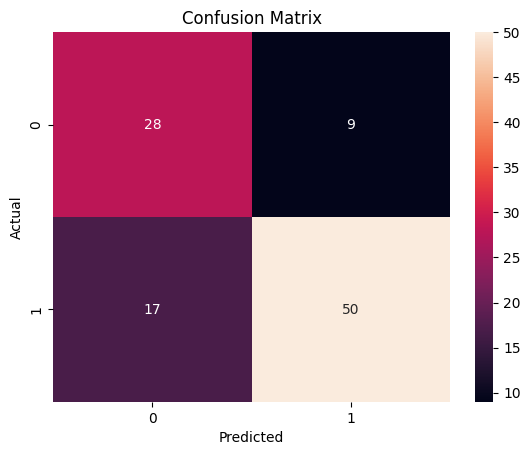

              precision    recall  f1-score   support

           0       0.62      0.76      0.68        37
           1       0.85      0.75      0.79        67

    accuracy                           0.75       104
   macro avg       0.73      0.75      0.74       104
weighted avg       0.77      0.75      0.75       104

ROC AUC: 0.8555869302137958


In [15]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, churn_prob))

In [16]:
importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": xgb_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

importance.head(10)
importance = importance.sort_values(
    by="Importance", ascending=False
).reset_index(drop=True)

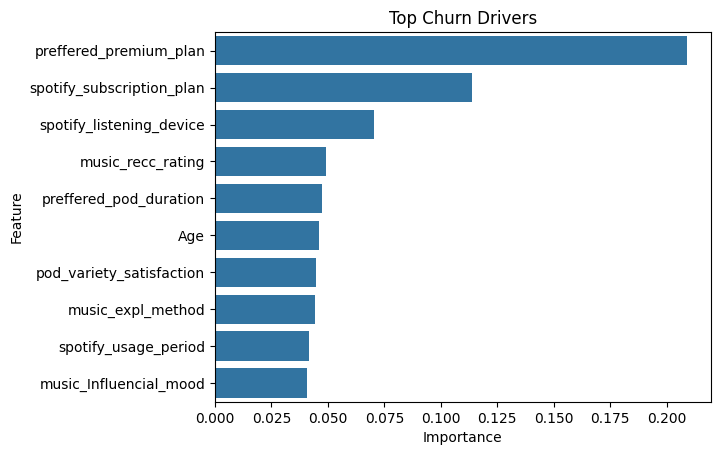

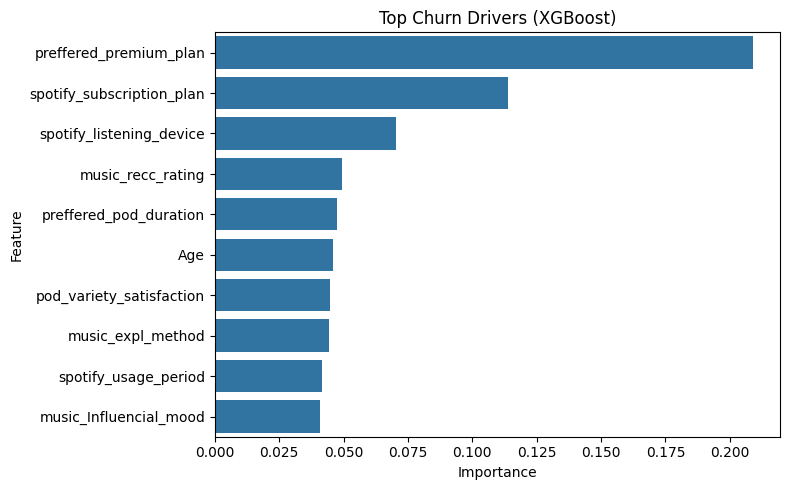

In [17]:
sns.barplot(x="Importance", y="Feature", data=importance.head(10))
plt.title("Top Churn Drivers")
plt.show()
plt.figure(figsize=(8, 5))
sns.barplot(x="Importance", y="Feature", data=importance.head(10), orient="h")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top Churn Drivers (XGBoost)")
plt.tight_layout()
plt.show()

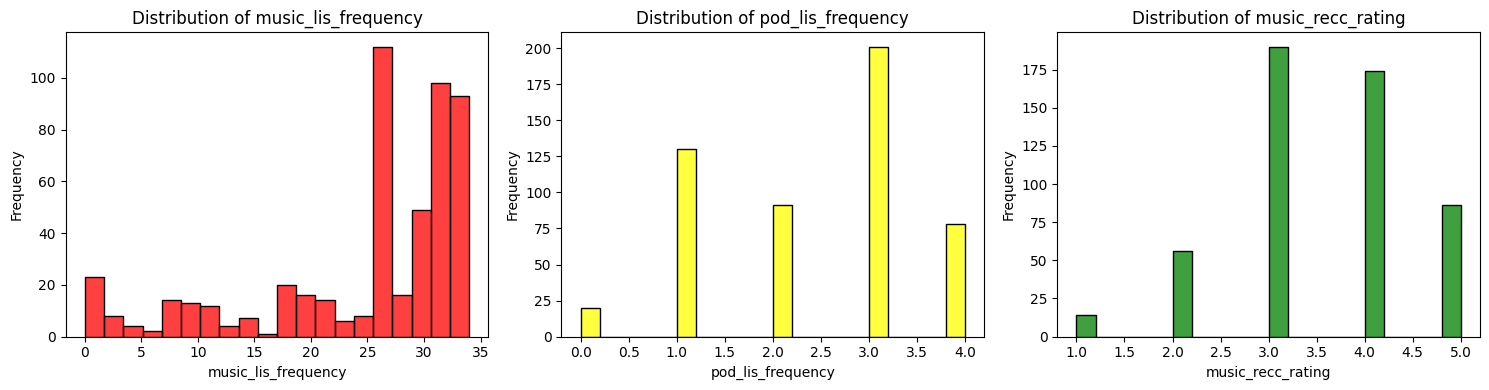

In [37]:
plt.figure(figsize=(15, 4))


plt.subplot(1, 3, 1)
sns.histplot(df["music_lis_frequency"], bins=20, color="red")
plt.title("Distribution of music_lis_frequency")
plt.xlabel("music_lis_frequency")
plt.ylabel("Frequency")


plt.subplot(1, 3, 2)
sns.histplot(df["pod_lis_frequency"], bins=20, color="yellow")
plt.title("Distribution of pod_lis_frequency")
plt.xlabel("pod_lis_frequency")
plt.ylabel("Frequency")


plt.subplot(1, 3, 3)
sns.histplot(df["music_recc_rating"], bins=20, color="green")
plt.title("Distribution of music_recc_rating")
plt.xlabel("music_recc_rating")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [33]:
full_prob = xgb_model.predict_proba(X)[:, 1]
full_pred = (full_prob >= 0.5).astype(int)

df["Prediction"] = full_pred
df["Pred_Prob"] = full_prob

In [34]:
df.to_csv("Spotify_churn_with_predictions.csv", index=False)

In [35]:
from google.colab import files
files.download("Spotify_churn_with_predictions.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>